In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import nltk
import time
import pickle
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from collections import Counter
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('sentiment.csv',encoding='ISO-8859-1',names=["sentiment", "ids", "date", "flag", "user", "text"])
df

sentiment         ids                          date      flag  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...            ...         ...                           ...       ...   
1599995          4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996          4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997          4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998          4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999          4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [3]:
df.dtypes

sentiment     int64
ids           int64
date         object
flag         object
user         object
text         object
dtype: object

In [4]:
df['sentiment'] = df['sentiment'].replace(4,1)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

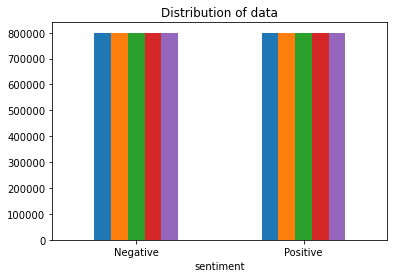

In [5]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [6]:
df.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

Commonly occuring stop words in dataset

In [7]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aruljayanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
corpus = []

word = df['text'].str.split()
new = word.values.tolist()
corpus=[word for i in new for word in i]

<BarContainer object of 10 artists>

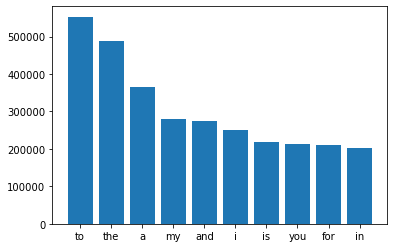

In [9]:
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, )

In [10]:
temp = pd.DataFrame(top)
fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words in stop word list')
fig.show()

Preprocessing

In [11]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with ''
        tweet = re.sub(urlPattern,'',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji,emojis[emoji])        
        # Replace @USERNAME to ''.
        tweet = re.sub(userPattern,'', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [13]:
# Storing data in lists.
df = df[['sentiment','text']]
text, sentiment = list(df['text']), list(df['sentiment'])
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aruljayanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 106 seconds


Word-Cloud for Negative tweets

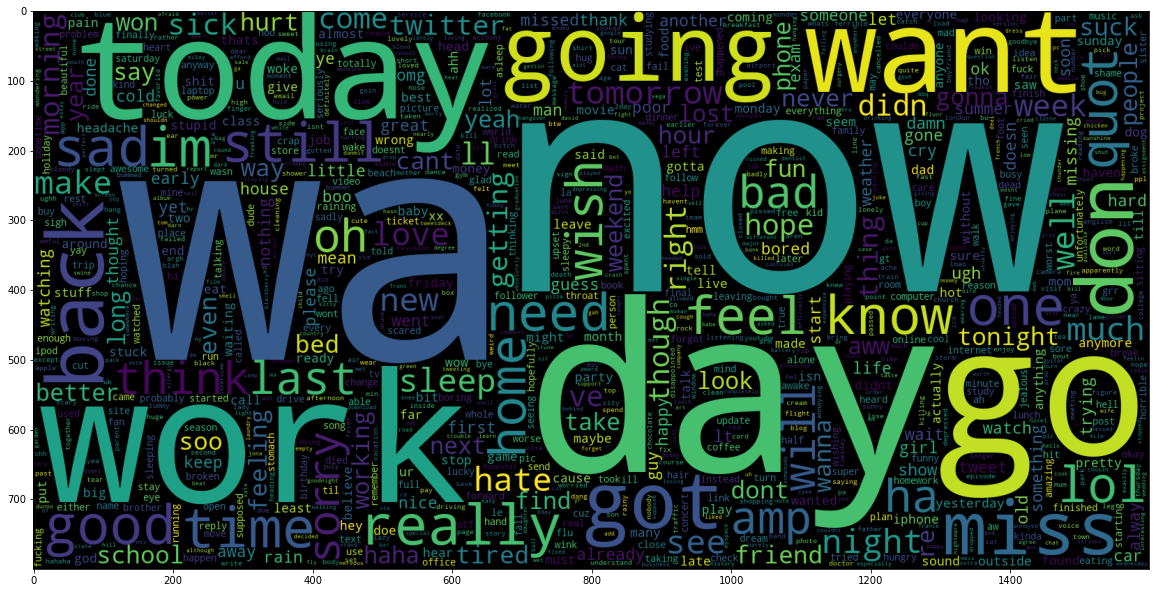

In [15]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word-Cloud for Positive tweets

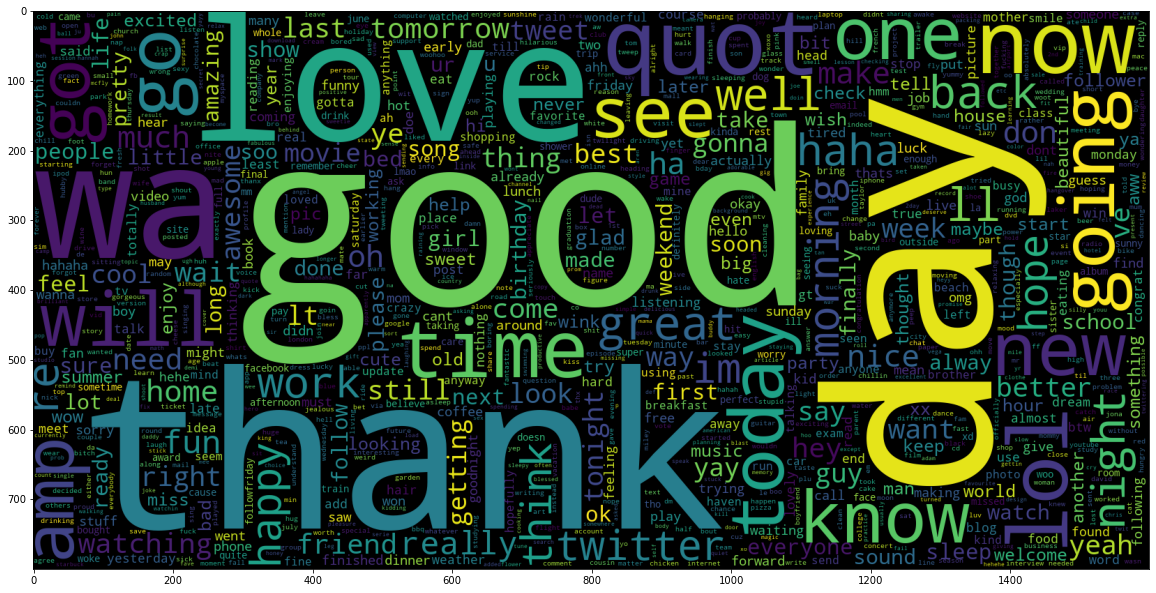

In [16]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


In [17]:
df['text']=processedtext

<ipython-input-17-78b126136eb0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df =  shuffle(df).reset_index(drop=True)

In [19]:
df

sentiment                                               text
0                1  awe look at you remembering my special little ...
1                0       thing are getting complicated again fuucckk 
2                1  almost there bro almost there have to finish a...
3                1     fulamak cantik sexy oo with the rungus hehehe 
4                1                                         thanks am 
...            ...                                                ...
1599995          1                              thanks for following 
1599996          1  think we all need oil change wash and wax ever...
1599997          1  partying it up tonight at lounge in downtown l...
1599998          0         being bored a usual amp amp lost my voice 
1599999          1    lady gaga inspires me to be fabulous every day 

[1600000 rows x 2 columns]

In [20]:
df=df.iloc[0:400000]

In [21]:
df['sentiment'].value_counts()

0    200270
1    199730
Name: sentiment, dtype: int64

In [22]:
y = df['sentiment'].map({True: 1, False: 0}).values
y

array([1, 0, 1, ..., 1, 0, 0])

In [23]:
t = time.time()
cv = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2, 2),max_features = 10)
X = cv.fit_transform(df['text']).toarray()
print(f'Bag of words feature extraction is complete')
print(f'Time Taken: {round(time.time()-t)} seconds')

Bag of words feature extraction is complete
Time Taken: 8 seconds


In [24]:
X.shape

(400000, 10)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify = y)

In [26]:
X_train.shape, X_test.shape

((380000, 10), (20000, 10))

In [27]:
y_train.shape, y_test.shape

((380000,), (20000,))

In [28]:
yz=pd.DataFrame(y_test)
yz[0].value_counts()

0    10013
1     9987
Name: 0, dtype: int64

In [30]:
svm_linear = svm.SVC(kernel='linear')
t0 = time.time()
svm_linear.fit(X_train, y_train)
t1 = time.time()
prediction_linear = svm_linear.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

Training time: 3167.571780s; Prediction time: 95.308710s


In [38]:
confusion_matrix(y_test, prediction_linear)

array([[ 257, 9735],
       [  88, 9920]])

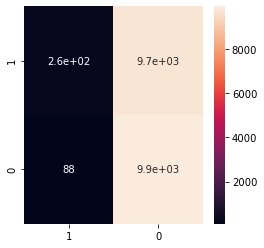

In [55]:
svm_ar=confusion_matrix(y_test, prediction_linear)
svm_ar=pd.DataFrame(svm_ar, index = [i for i in "10"],columns = [i for i in "10"])
plt.figure(figsize = (4,4))
sns.heatmap(svm_ar, annot=True)

In [39]:
accuracy_score(y_test, prediction_linear)

0.50885

In [45]:
f1_score(y_test, prediction_linear)

0.6688467113912956

In [29]:
t = time.time()
cv = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(1, 2),max_features = 1000)
X = cv.fit_transform(df['text']).toarray()
print(f'Bag of words feature extraction is complete')
print(f'Time Taken: {round(time.time()-t)} seconds')

Bag of words feature extraction is complete
Time Taken: 10 seconds


In [30]:
X.shape

(400000, 1000)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify = y)

In [32]:
X_train.shape, X_test.shape

((380000, 1000), (20000, 1000))

In [33]:
y_train.shape, y_test.shape

((380000,), (20000,))

In [34]:
yz=pd.DataFrame(y_test)
yz[0].value_counts()

0    10013
1     9987
Name: 0, dtype: int64

In [104]:
rf = RandomForestClassifier()
t0 = time.time()
rf.fit(X_train, y_train)
t1 = time.time()
prediction_rf=rf.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

Training time: 4423.597643s; Prediction time: 5.590628s


In [105]:
confusion_matrix(y_test, prediction_rf)

array([[6946, 3046],
       [2495, 7513]])

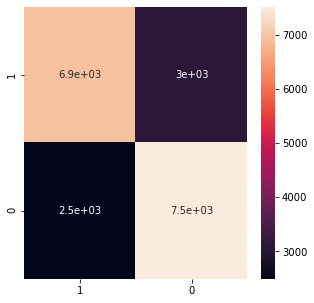

In [106]:
rf_ar=confusion_matrix(y_test, prediction_rf)
rf_ar=pd.DataFrame(rf_ar, index = [i for i in "10"],columns = [i for i in "10"])
plt.figure(figsize = (5,5))
sns.heatmap(rf_ar, annot=True)

In [107]:
accuracy_score(y_test, prediction_rf)

0.72295

In [108]:
f1_score(y_test, prediction_rf)

0.7305878348811202

In [111]:
pickle.dump(svm_linear, open('svm_classifier.sav', 'wb'))

In [112]:
pickle.dump(rf, open('rf_classifier.sav', 'wb'))

In [31]:
xgb = XGBClassifier()
t0 = time.time()
xgb.fit(X_train, y_train)
t1 = time.time()
prediction_xgb=xgb.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

Training time: 511.387194s; Prediction time: 0.423263s


In [32]:
confusion_matrix(y_test, prediction_xgb)

array([[6472, 3534],
       [1853, 8141]])

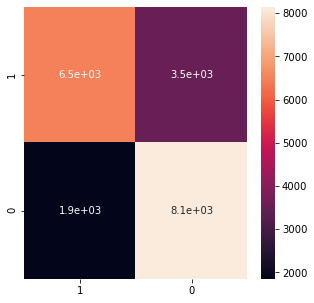

In [33]:
xgb_ar=confusion_matrix(y_test, prediction_xgb)
xgb_ar=pd.DataFrame(xgb_ar, index = [i for i in "10"],columns = [i for i in "10"])
plt.figure(figsize = (5,5))
sns.heatmap(xgb_ar, annot=True)

In [34]:
accuracy_score(y_test, prediction_xgb)

0.73065

In [35]:
f1_score(y_test, prediction_xgb)

0.7513960035073146

In [32]:
pickle.dump(xgb, open('xgb_classifier.sav', 'wb'))

In [35]:
ada = AdaBoostClassifier()
t0 = time.time()
ada.fit(X_train, y_train)
t1 = time.time()
prediction_ada=ada.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

Training time: 825.272478s; Prediction time: 2.336029s


In [36]:
confusion_matrix(y_test, prediction_ada)

array([[4380, 5633],
       [1160, 8827]])

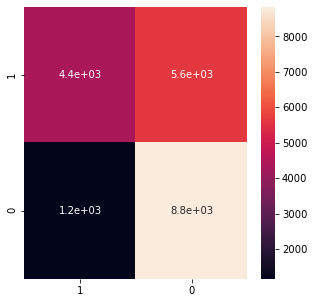

In [37]:
ada_ar=confusion_matrix(y_test, prediction_ada)
ada_ar=pd.DataFrame(ada_ar, index = [i for i in "10"],columns = [i for i in "10"])
plt.figure(figsize = (5,5))
sns.heatmap(ada_ar, annot=True)

In [38]:
accuracy_score(y_test, prediction_ada)

0.66035

In [39]:
f1_score(y_test, prediction_ada)

0.7221335951241462

In [40]:
pickle.dump(ada, open('ada_classifier.sav', 'wb'))